In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import PathologicalPartitioner

partitioner = PathologicalPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    num_classes_per_partition=2,
    class_assignment_mode="random", # ['random', 'deterministic', 'first-deterministic']
    seed=42
)

def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)
            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy.fedavg import FedAvg
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
def fit_config_fn(server_round: int):
    """Return training configuration dict for each round."""
    config={
        "current_round":server_round,
        "mu":0.01,
    }
    return config

strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    on_fit_config_fn=fit_config_fn,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2160) 2025-04-28 15:31:25.658098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2160) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2160) E0000 00:00:1745854285.746505    2160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2160) E0000 00:00:1745854285.772027    2160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 97669.83 examples/s]
(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2159) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2159) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2159) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2159) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2159)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.1653


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 's

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_reco

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_reco

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_reco

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.5043
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159)

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_rec

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_reco

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.3833
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.4805
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.4378
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 2 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.4230
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.4066
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={},

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2160) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.5395
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 's

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.5663


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, '

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor p

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3
(ClientAppActor pid=2159) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.4330
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.5979
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.6084
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(
(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(
(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.6029
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 's

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.6191
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-i

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.5047
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.3738
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_reco

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(Client

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.5838
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=215

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.6107
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, '

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.4632


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 129719825035

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_reco

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_reco

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2
(ClientA

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.6300
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.4772
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.4648
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 size: 2499


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.5167
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.4869
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-i

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor p

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.4992
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.4648
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.8061
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 's

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.5251
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(Client

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.6180
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.6504
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Accuracy: 0.6375
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.6133
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(
(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.7971
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) 


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 2 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 2 size: 3334 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.6171
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 size: 2499


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.6525
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 3x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.5903
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(
(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2159) 
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.6215
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(
(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.7592


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(
(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 's

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(
(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.3952
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   co

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3
(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.6586


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(Client

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_rec

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.6499
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2160) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 3x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.5123
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_reco

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_recor

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_rec

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.8042
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5
(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 8


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Accuracy: 0.7653
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 6
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor 

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4
(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.6293
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pi

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6
(ClientA

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 8 test size: 500 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.7818
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pi

(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 5 size: 2500
(ClientAppActor pid=2159) Partition 5 train size: 2000
(ClientAppActor pid=2159) Partition 5 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 2


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 4 test size: 501 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.7799
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5
(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 3


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 3 size: 3333
(ClientAppActor pid=2159) Partition 3 train size: 2666
(ClientAppActor pid=2159) Partition 3 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 0


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 0 size: 2501
(ClientAppActor pid=2159) Partition 0 train size: 2000
(ClientAppActor pid=2159) Partition 0 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.7600


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 16869154466137564226, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2160)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 8 size: 2499
(ClientAppActor pid=2159) Partition 8 train size: 1999
(ClientAppActor pid=2159) Partition 8 test size: 500


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 3


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1433151254711349330, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 0


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 0 size: 2501
(ClientAppActor pid=2160) Partition 0 train size: 2000
(ClientAppActor pid=2160) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 4 size: 2501
(ClientAppActor pid=2160) Partition 4 train size: 2000
(ClientAppActor pid=2160) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2159) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=2160) Partition 6 test size: 667 [repeated 3x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.7918
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 15651916934959796384, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 4
(ClientAppActor pid=2159) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid

(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2159) Partition 2 size: 3334
(ClientAppActor pid=2159) Partition 2 train size: 2667
(ClientAppActor pid=2159) Partition 2 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 7374534918747361903, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2160)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2160)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2160) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2160) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 6 size: 3333
(ClientAppActor pid=2160) Partition 6 train size: 2666
(ClientAppActor pid=2160) Partition 6 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 12971982503580936364, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2160) Partition 3 size: 3333
(ClientAppActor pid=2160) Partition 3 train size: 2666
(ClientAppActor pid=2160) Partition 3 test size: 667


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 4 size: 2501
(ClientAppActor pid=2159) Partition 4 train size: 2000
(ClientAppActor pid=2159) Partition 4 test size: 501
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 2769092266846040285, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 5


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 5 size: 2500
(ClientAppActor pid=2160) Partition 5 train size: 2000
(ClientAppActor pid=2160) Partition 5 test size: 500
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2159)   array_records={},
(ClientAppActor pid=2159)   metric_records={},
(ClientAppActor pid=2159)   config_records={}
(ClientAppActor pid=2159) ), 'run_config': {}}
(ClientAppActor pid=2159) Using partition_id: 6


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2159)   warnings.warn(


(ClientAppActor pid=2159) Partition 6 size: 3333
(ClientAppActor pid=2159) Partition 6 train size: 2666
(ClientAppActor pid=2159) Partition 6 test size: 667
(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1329049202584726948, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 8


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 8 size: 2499
(ClientAppActor pid=2160) Partition 8 train size: 1999
(ClientAppActor pid=2160) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2160) Context data: {'run_id': 7755297885817615125, 'node_id': 1901820656020313332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2160)   array_records={},
(ClientAppActor pid=2160)   metric_records={},
(ClientAppActor pid=2160)   config_records={}
(ClientAppActor pid=2160) ), 'run_config': {}}
(ClientAppActor pid=2160) Using partition_id: 2


(ClientAppActor pid=2160) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2160)   warnings.warn(


(ClientAppActor pid=2160) Partition 2 size: 3334
(ClientAppActor pid=2160) Partition 2 train size: 2667
(ClientAppActor pid=2160) Partition 2 test size: 667
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 17676665871787840006, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2159) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=2159) Context data: {'run_id': 7755297885817615125, 'node_id': 16895266594974225054, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2159)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2159)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2159) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2159) Using partition_id: 4 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 9937.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06170215183084241
INFO :      		round 2: 0.04606684143748078
INFO :      		round 3: 0.04869998757735122
INFO :      		round 4: 0.04548606196755241
INFO :      		round 5: 0.05137519634484323
INFO :      		round 6: 0.05129736160034272
INFO :      		round 7: 0.05158983958865494
INFO :      		round 8: 0.044407311274223094
INFO :      		round 9: 0.04072421090848315
INFO :      		round 10: 0.049049753952197864
INFO :      		round 11: 0.03659756043103777
INFO :      		round 12: 0.037405170527150686
INFO :      		round 13: 0.035637438945371115
INFO :      		round 14: 0.03435291890623255
INFO :      		round 15: 0.04256887953003622
INFO :      		round 16: 0.0504974355285192
INFO :      		round 17: 0.03566457480148732
INFO :      		round 18: 0.033186333408469305
INFO :      		round 1

Round 50: Test Accuracy: 0.5155
(ClientAppActor pid=2159) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=2159) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=2159) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2159)   warnings.warn( [repeated 2x across cluster]


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.1653
Round 2: 0.5043
Round 3: 0.3833
Round 4: 0.4805
Round 5: 0.4378
Round 6: 0.4230
Round 7: 0.4066
Round 8: 0.5395
Round 9: 0.5663
Round 10: 0.4330
Round 11: 0.5979
Round 12: 0.6084
Round 13: 0.6029
Round 14: 0.6191
Round 15: 0.5047
Round 16: 0.3738
Round 17: 0.5838
Round 18: 0.6107
Round 19: 0.4632
Round 20: 0.6300
Round 21: 0.4772
Round 22: 0.4648
Round 23: 0.5167
Round 24: 0.4869
Round 25: 0.4992
Round 26: 0.4648
Round 27: 0.8061
Round 28: 0.5251
Round 29: 0.6180
Round 30: 0.6504
Round 31: 0.6375
Round 32: 0.6133
Round 33: 0.7971
Round 34: 0.6171
Round 35: 0.6525
Round 36: 0.5903
Round 37: 0.6215
Round 38: 0.7592
Round 39: 0.3952
Round 40: 0.6586
Round 41: 0.6499
Round 42: 0.5123
Round 43: 0.8042
Round 44: 0.7653
Round 45: 0.6293
Round 46: 0.7818
Round 47: 0.7799
Round 48: 0.7600
Round 49: 0.7918
Round 50: 0.5155



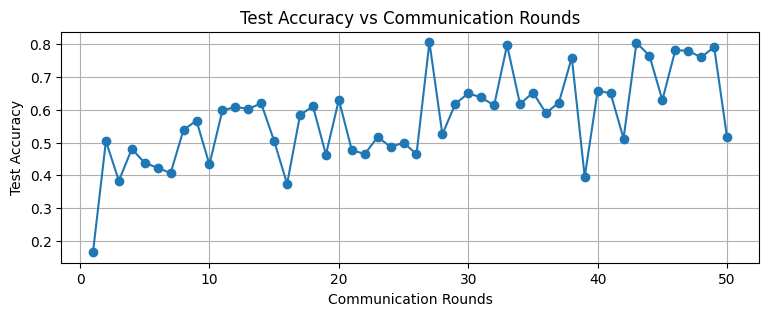

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()